This script compares the accuracy of the algorithm against the human ratings.
Is the number of visible Openpose markers relevant for the rating?

In [52]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
# Bayes packages
import jax.numpy as np
import seaborn as sns
import numpyro
from numpyro.diagnostics import hpdi

Load the data of the rater and the algorithm

In [148]:
# Load data from algorithmic tracking
algoFiles = glob.glob("data/P*.txt")
df_algoFiles = (pd.read_csv(f, header = None) for f in algoFiles)
df_algo   = pd.concat(df_algoFiles, ignore_index=True, axis = 0)

# Load data from manual ratings
raterFiles = glob.glob("data/data_Rater*.csv")
df_raterFiles = (pd.read_csv(f, header = 0) for f in raterFiles)
df_rater   = pd.concat(df_raterFiles, ignore_index=True)

Prepare the data in long format

In [149]:
# Only take the last judgement of each rater
df_rater.drop_duplicates(subset=['Rater', 'Frame', 'Trial'], keep='last', inplace = True)

# Rename columns
df_algo.columns = ["Trial", "AOI", "1", "2", "3", "4", "5", "6", "VisiblePoints", "7", "8" ]

# Add frame number column
df_algo["Frame"] = df_algo.groupby(['Trial']).cumcount()

# Set datatypes
df_algo["Trial"] = df_algo["Trial"].astype("string")
df_algo["AOI"] = df_algo["AOI"].astype("string")
df_rater["Trial"] = df_rater["Trial"].astype("string")
df_rater["Label"] = df_rater["Label"].astype("string")

# Rename the labels to match the AOI from the algorithmic approach
df_algo['AOI'] = df_algo['AOI'].str.replace("Nose","Head")
df_algo['AOI'] = df_algo['AOI'].str.replace("Neck","Chest")
df_algo['AOI'] = df_algo['AOI'].str.replace("LElbow","Left arm")
df_algo['AOI'] = df_algo['AOI'].str.replace("RElbow","Right arm")
df_algo['AOI'] = df_algo['AOI'].str.replace("RKnee","Right leg")
df_algo['AOI'] = df_algo['AOI'].str.replace("LKnee","Left leg")
df_algo['AOI'] = df_algo['AOI'].str.replace("MidHip","Pelvis")

# merge on trial and frame
df = pd.merge(df_algo, df_rater, how = 'inner', on = ["Trial", "Frame"])

# Get percentage of correctly identified frames
df['Correct'] = df.AOI == df.Label
df['Correct'].astype(int)

# Get percentage of correctly identified frames
df['Correct'] = df.AOI == df.Label
df['Correct'] = df['Correct'].astype(int)
df['RaterID'], _ = pd.factorize(df.Rater)
# df_algo["VisiblePoints"] = df_algo["VisiblePoints"].astype(int)

# Only keep interesting columns
df.drop(columns=["1", "2", "3", "4", "5", "6", "7", "8"], inplace = True)

# Save the data where the "other" are included
df_other = df

# Subset the other column (Others are not relevant)
df = df[df.AOI != "Other"]
df = df[df.Label != "Other"]

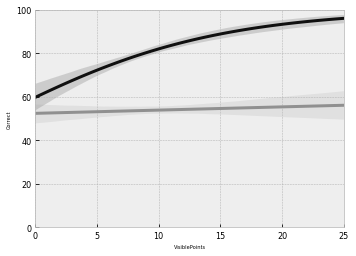

In [206]:
# Logistic regression
sns.set_context(rc=
    {
        'pgf.texsystem': 'pdflatex',
        'font.family': 'serif',
        "font.size":8,
        "axes.titlesize":8,
        "axes.labelsize":5,
        'pgf.texsystem': 'pdflatex',
        'axes.titlesize': 'medium',
        'text.usetex': True,
        'pgf.rcfonts': False,
        'axes.unicode_minus': False
        
    }
)

# Figure settings for export
pts_document_with = 400. # How wide is the page
pts_per_inch = 1. / 72.27
figure_width = pts_document_with * pts_per_inch

# Create figure and plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (figure_width,4), sharey = True)
p = sns.scatterplot() # Empty plot

p.set_xlim(0,25)
p.set_ylim(0,1)

p.set_yticklabels(np.round(p.get_yticks()*100).astype(int))

p = sns.regplot('VisiblePoints', 'Correct', df, logistic=True, scatter=False, truncate=False, color="#101010")
p = sns.regplot('VisiblePoints', 'Correct', df_other, logistic=True, scatter=False, truncate=False, color="#909090")


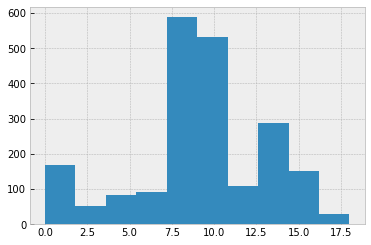

In [170]:
# Bayesian regression
# http://num.pyro.ai/en/latest/tutorials/bayesian_regression.html

plt.style.use('bmh')
plt.hist(df.VisiblePoints, zorder=2)

# Standardize predictor
standardize = lambda x: (x - x.mean()) / x.std()
df['VisiblePoints_z'] = df.VisiblePoints.pipe(standardize)




                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.36      0.05      1.36      1.27      1.45   6485.24      1.00
        bC      0.00      0.50      0.01     -0.86      0.80   6025.13      1.00

Number of divergences: 0


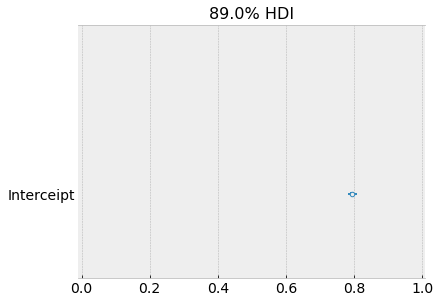

In [200]:
# https://fehiepsi.github.io/rethinking-numpyro/11-god-spiked-the-integers.html
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)


def model(Correct=None, VisiblePoints=None):
    a = numpyro.sample('a', dist.Normal(0., 10))
    bC = numpyro.sample('bC', dist.Normal(0., 0.5))
    logit_p = a # Likelihood
    numpyro.sample('obs', dist.Binomial(logits=logit_p), obs=Correct)


# Run NUTS.
num_warmup, num_samples = 1000, 2000
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains = 4)
mcmc.run(rng_key_, Correct=df.Correct.values, VisiblePoints=df.VisiblePoints_z.values)
mcmc.print_summary()
post = mcmc.get_samples(group_by_chain=True)

# # Laplace approximation
# from numpyro.infer.autoguide import AutoLaplaceApproximation
# from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
# import numpyro.optim as optim
# from jax import lax
# from jax.scipy.special import expit
# import arviz as az

# # Checking the prior (OFF!)
# m11_1 = AutoLaplaceApproximation(model)
# svi = SVI(model, m11_1, optim.Adam(1), Trace_ELBO(), Correct=df.Correct.values)
# init_state = svi.init(random.PRNGKey(0))
# state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
# p11_1 = svi.get_params(state)
# prior = Predictive(m11_1.model, num_samples=10000)(random.PRNGKey(1999))


# print(expit(prior['a']))
# prior_alpha = expit(prior['a'])
# az.plot_kde(prior_alpha, bw=0.3)

a = expit(post['a'])
az.plot_forest({"Intercept": a}, combined=True, hdi_prob=0.89)
plt.gca().set(xlim=(-0.01, 1.01))
plt.show()
